<h1 align="center">Bobble-Bot Analysis Report</h1>
<h3><center><i>Integration Test Results Summary</i></center></h3>
<img src="https://raw.githubusercontent.com/super-owesome/bobble_controllers/master/docs/imgs/BobbleCAD.png" alt="BobbleBot CAD" height="350" width="250">

# Introduction
This report summarizes the results from the Bobble-Bot automated integration tests. These are tests of the Bobble-Bot 
controller running within the Gazebo simulation environment. The tests run on every push to the Bobble-Bot balance controller's
source code repository by making use of [GitLab CI](https://about.gitlab.com/product/continuous-integration/). 
They are designed to ensure that the Bobble-Bot balance controller always remains in working order. [ROS test](http://wiki.ros.org/rostest) 
is used as the primary testing framework. Each integration test does a few simple pass/fail checks along with 
recording status data during the simulation run. This [Jupyter Notebook](https://jupyter.org/) is used report 
the simulation data recorded from these tests in an automated summary report made available for download as a test 
artifact by the CI server. The report gives developers insight into how their changes impact the integrated controller 
performance. The table below summarizes the tests that are performed.

| Test Name           | Description                                  | Source Code    |
| ------------------- | -------------------------------------------- | -------------- |
| No Balance          | Bobble-Bot uncontrolled                      | [TBD](https://github.com/super-owesome/bobble_controllers) |
| Impulse force       | Balance control active, impulse applied.     | [TBD](https://github.com/super-owesome/bobble_controllers) |
| Balance Control     | Balance control active, drive around.        | [TBD](https://github.com/super-owesome/bobble_controllers) |
| Drive square        | Balance control active, drive in square.     | [TBD](https://github.com/super-owesome/bobble_controllers) |

The remainder of this notebook describes how to analyze the results from these tests and 
presents some relevant plots capturing the controller performance during each.

<center>
  <img src="https://raw.githubusercontent.com/super-owesome/bobble_controllers/master/docs/imgs/BobbleBotGazebo.png" alt="BobbleBot CG" height="400" width="640"/>
</center>


## Loading Bobble-Bot Simulation Data

Using the gazebo-ros packages, one can log data as the simulator runs each test and store it in a ROS bag format. 
The simulation data can then be analyzed with Python using [Pandas](https://pandas.pydata.org/). This article discusses 
how to [load ROS bag files into Pandas](https://nimbus.unl.edu/2014/11/using-rosbag_pandas-to-analyze-rosbag-files/). 
The file nb_env.py is used to load in the data from the tests into a Python dictionary of Pandas 
[DataFrames](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.html).
Consult nb_env.py to see exactly how this is done. The ROS bag reader and Pandas are used during the automated tests to convert the data from a bag file to a CSV file.
This is done to make the test artifact data more human readable. For the purposes of 
this notebook, we will read in the CSV files. Consult parsing_tools.py for a set of 
function that can handle ROS bag files.

In [1]:
# Load anaylsis environment file. This file defines data directories
# and imports all needed Python packages for this notebook.
exec(open("nb_env.py").read())
runs = ['no_balance', 'balance', 'impulse_force', 'drive_square_js_response']
# Print out the df dictionary keys (the test run names)
df.keys()

Reading all csv files in directory : 
/home/mike/BobbleBotSim/src/bobble_controllers/test/data
Successfully loaded runs : 


['impulse_force', 'drive_square_js_response', 'balance', 'no_balance']

## Loading the Plot Configuration
YAML is used to define a default matplotlib configuration for each plot used in this file. This is done to set a title, line styles, axis labels, 
the legend, and other relevant configuration parameters for each plot. Consult plots.yaml to see the full default configuration used by this 
report. A summary of the default tilt control plot configuration is given below as an example.
```yaml
tilt_control:
  title : 'Tilt Control'
  desired_y_var: 'DesiredTilt'
  actual_y_var: 'Tilt'
  runs : ['balance']
  x_label: 'Time (s)'
  y_label: 'Tilt (deg)'
  colors : ['red', 'blue']
  legend:
     desired:
       color: 'red'
       linestyle: '-'
     actual:
       color: 'blue'
       linestyle: '-'
  xlim: [0.0, 10.0]
```
The code below loads the configuration objects into a plot config Python dictionary, pc. Any of these objects can be 
copied, or the default values can be overwritten before creating the final plot. Some examples of this will be shown in 
later sections of this report.

In [3]:
# Set paths to relevant data directories and config files
plot_config_file = os.path.abspath(os.path.join(os.getcwd(),'plots.yaml'))
# Load configs and data
pc = parse_config_file(plot_config_file)

Loading configs from file : /home/mike/BobbleBotSim/src/bobble_controllers/test/plots.yaml


## Pre-Processing
This section applies any and all pre-processing steps needed on the data set. Examples include trimming the data, removing bias, filtering, and applying transforms.
For this report, we compute some additional data using a differential drive robot model.

### Compute Auxiliary Data
Currently, Bobble-Bot does not track its x,y world position internally because it is not needed by the balance controller. For this analysis, we 
would like to look at some commanded trajectories in world coordinates. In order to do this, we use a kinematic model for a differential drive 
robot to compute translational and rotational state from the raw simulation data. The model to be used is described in the graphic below.
<center>
  <img src="https://raw.githubusercontent.com/super-owesome/bobble_controllers/master/docs/imgs/DifferentialDrive.png" alt="Differential Drive Model" height="400" width="375"/>
</center>
The Python code below defines a function that uses this model in order to compute x, y position and velocity in world co-ordinates for each test run.

In [4]:
import math

def compute_auxiliary_terms(df, fwd_vel_scale=1.0, turn_rate_scale=1.0):
    turn_rate = turn_rate_scale*df['TurnRate']
    heading = scipy.integrate.cumtrapz(y=turn_rate.values, x=turn_rate.index)
    heading = np.append(heading, heading[-1])
    fwd_vel = fwd_vel_scale*df['ForwardVelocity']
    x_vel = fwd_vel * np.cos(heading*np.pi/180.0)
    y_vel = fwd_vel * np.sin(heading*np.pi/180.0)
    x_pos = scipy.integrate.cumtrapz(y=x_vel.values, x=x_vel.index)
    x_pos = np.append(x_pos, x_pos[-1])
    y_pos = scipy.integrate.cumtrapz(y=y_vel.values, x=y_vel.index)
    y_pos = np.append(y_pos, y_pos[-1])
    desired_fwd_vel = fwd_vel_scale*df['DesiredVelocity']
    desired_turn_rate = turn_rate_scale*df['DesiredTurnRate']
    desired_heading = scipy.integrate.cumtrapz(y=desired_turn_rate.values, x=desired_turn_rate.index)
    desired_heading = np.append(desired_heading, desired_heading[-1])
    desired_x_vel = desired_fwd_vel * np.cos(desired_heading*np.pi/180.0)
    desired_y_vel = desired_fwd_vel * np.sin(desired_heading*np.pi/180.0)
    desired_x_pos = scipy.integrate.cumtrapz(y=desired_x_vel.values, x=desired_x_vel.index)
    desired_x_pos = np.append(desired_x_pos, desired_x_pos[-1])
    desired_y_pos = scipy.integrate.cumtrapz(y=desired_y_vel.values, x=desired_y_vel.index)
    desired_y_pos = np.append(desired_y_pos, desired_y_pos[-1])
    df['Heading'] = heading
    df['DerivedHeading'] = heading
    df['DesiredHeading'] = desired_heading
    df['DesiredXPos'] = desired_x_pos
    df['DesiredYPos'] = desired_y_pos
    df['DerivedXPos'] = x_pos
    df['DerivedYPos'] = y_pos

for run in runs:
    compute_auxiliary_terms(df[run])

KeyError: 'TurnRate'

With that, we now have everything we need to create some useful plots summarizing the control
performance for each test run. Before creating the plots, let's show some examples of basic 
DataFrame manipulations using features within the Pandas library. Consult the Pandas documentation 
to learn more.

### Print sim data in tabular form
We can print the first five rows of the data in a nice tabular form like so.

In [4]:
n_rows = 5
df['no_balance'].head(n_rows)

,time,bobble_bobble_balance_controller_bb_controller_status__ControlMode,bobble_bobble_balance_controller_bb_controller_status__DesiredTilt,bobble_bobble_balance_controller_bb_controller_status__DesiredTurnRate,bobble_bobble_balance_controller_bb_controller_status__DesiredVelocity,bobble_bobble_balance_controller_bb_controller_status__ForwardVelocity,bobble_bobble_balance_controller_bb_controller_status__Heading,bobble_bobble_balance_controller_bb_controller_status__HeadingEffort,bobble_bobble_balance_controller_bb_controller_status__LeftMotorEffortCmd,bobble_bobble_balance_controller_bb_controller_status__LeftMotorPosition,...,bobble_bobble_balance_controller_bb_controller_status__TiltEffort,bobble_bobble_balance_controller_bb_controller_status__TiltRate,bobble_bobble_balance_controller_bb_controller_status__TurnRate,time.1,DerivedHeading,DesiredHeading,DesiredXPos,DesiredYPos,DerivedXPos,DerivedYPos
0,0.000,0.0,0.0,0.0,0.0,-1.782923e-07,0.579181,0.0,0.0,-0.002052,...,0.0,-1.412423,0.531274,0.000,0.579181,0.0,0.0,0.0,-4.702652e-07,-4.676904e-09
1,0.005,0.0,0.0,0.0,0.0,-7.622847e-07,0.567608,0.0,0.0,-0.002056,...,0.0,0.468921,0.627087,0.005,0.567608,0.0,0.0,0.0,-2.351699e-06,8.977683e-09
2,0.012,0.0,0.0,0.0,0.0,-3.000822e-06,-0.665623,0.0,0.0,-0.002069,...,0.0,0.344808,-0.650232,0.012,-0.665623,0.0,0.0,0.0,-7.324706e-06,1.036442e-07
3,0.015,0.0,0.0,0.0,0.0,-6.947113e-06,-1.274103,0.0,0.0,-0.002102,...,0.0,-0.407358,-1.816231,0.015,-1.274103,0.0,0.0,0.0,-1.203962e-05,2.108299e-07
4,0.020,0.0,0.0,0.0,0.0,-2.485148e-06,-1.381127,0.0,0.0,-0.002135,...,0.0,0.384271,0.599270,0.020,-1.381127,0.0,0.0,0.0,-1.383514e-05,2.659799e-07


### Search for a column
Here's how to search for a column(s) in a DataFrame.

In [8]:
search_string = 'Vel'
found_data = df['no_balance'].filter(regex=search_string)
found_data.head()

,bobble_bobble_balance_controller_bb_controller_status__DesiredVelocity,bobble_bobble_balance_controller_bb_controller_status__ForwardVelocity,bobble_bobble_balance_controller_bb_controller_status__LeftMotorVelocity,bobble_bobble_balance_controller_bb_controller_status__RightMotorVelocity
0,0.0,-1.782923e-07,0.000000,0.000000
1,0.0,-7.622847e-07,-0.000988,-0.000995
2,0.0,-3.000822e-06,-0.003891,-0.003891
3,0.0,-6.947113e-06,-0.008759,-0.008759
4,0.0,-2.485148e-06,-0.001945,-0.001946


Many more data processing and manipulation functions are possible. Consult the 
[Pandas documentation](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.html) 
for more information.

# The Results
That's enough prep work. Now let's look at the results

## Balance vs No Balance
To start, we can create a plot of the tilt angle for the balanced versus un-balanced test case.

### Tilt Plot
To make this plot we start with the 'measured_tilt' default plot configuration. The lines of code below
show an example of making a copy of this configuration object and specifying some user defined overrides.
Once the plot configuration object is defined (cfg), we can call the make_static_plot function
to produce the plot. The make_static_plot function takes the data frame, a plot config dictionary object, 
and a string for the plot name.

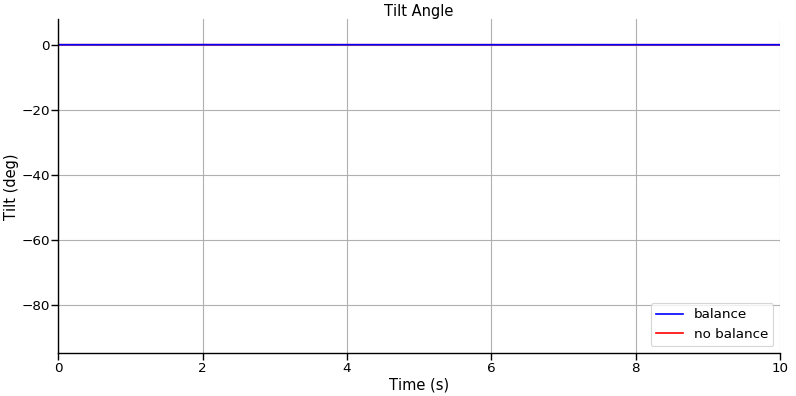

In [6]:
%matplotlib inline
cfg = pc['measured_tilt'].copy()
cfg['runs'] = ['no_balance', 'balance']
cfg['colors'] = ['red', 'blue']
cfg['linestyles'] = ['-', '-']
cfg['legend'] = {
    'no balance': {
        'color': 'red',
        'linestyle': '-'
    },
    'balance': {
        'color': 'blue',
        'linestyle': '-'
    },
}
cfg['xlim'] = [0.0, 10.0]
make_static_plot(df, cfg, 'TiltVsTime')

### Velocity Plot
Following the tilt plot example, we can also make a comparison plot of Bobble-Bot's velocity during the no balance and balance 
simulation runs.

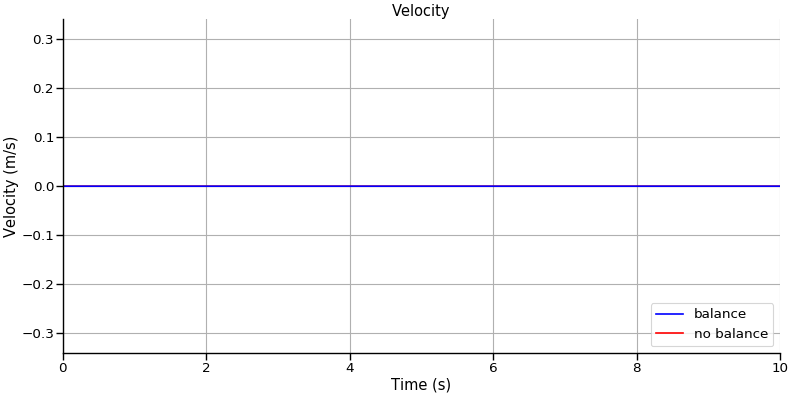

In [7]:
%matplotlib inline
cfg = pc['velocity'].copy()
cfg['runs'] = ['no_balance', 'balance']
cfg['colors'] = ['red', 'blue']
cfg['linestyles'] = ['-', '-']
cfg['legend'] = {
    'no balance': {
        'color': 'red',
        'linestyle': '-'
    },
    'balance': {
        'color': 'blue',
        'linestyle': '-'
    },
}
cfg['xlim'] = [0.0, 10.0]
make_static_plot(df, cfg, 'VelocityVsTime')

These tilt and velocity comparisons for the no balance and balance runs show a simple example 
analysis that captures the performance that we should expect once balance mode is activated 
on the robot.

## Impulse Force Test
Another useful test for evaluating the balance controller is to look at how it performs under an 
applied impulse force. To do that we can look at the tilt and velocity control performance 
after the impulse is applied. Let's start with looking at the velocity controller

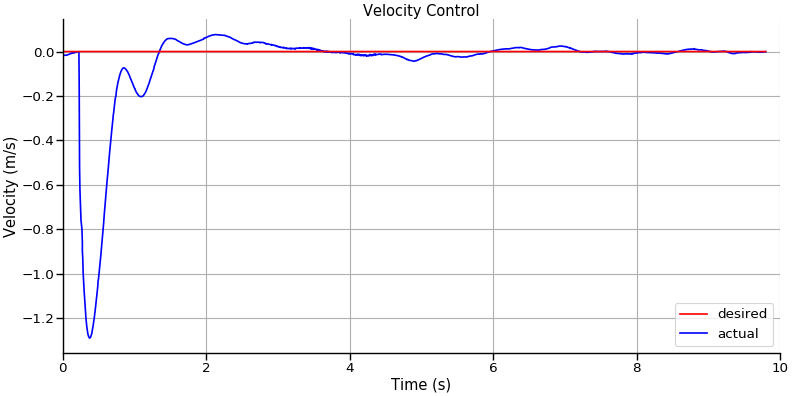

In [40]:
%matplotlib inline
cfg = pc['velocity_control'].copy()
cfg['runs'] = ['impulse_force']
cfg['xlim'] = [0, 10]
make_static_plot(df, cfg, 'ImpulseVelocityControl', plot_func=desired_vs_actual_for_runs)

This plot shows what you would expect for an impulse force applied in the -X direction. During this 
test the robot is in the balance mode. In this mode, the robot is trying to hold zero velocity. The 
applied impulse cause the robot to quickly accelerate in the -X direction. The job of the velocity 
controller is to reject this impulse by controlling the velocity back to zero. The plot above shows 
that the velocity controller is able to achieve its goal. In order to reject the -X disturbance force, 
the velocity controller modulates the desired tilt. In response to the -X impulse, the velocity controller 
commands the robot to tilt forward. The tilt controller then commands torque to each motor to achieve 
this tilt angle. This tilting motion serves to simultaneously control the velocity and reject the 
disturbance. Let's look at the tilt response to see this in action.

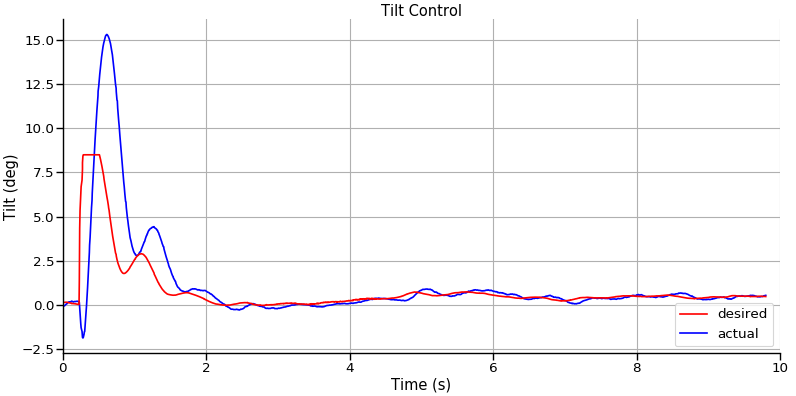

In [41]:
%matplotlib inline
cfg = pc['tilt_control'].copy()
cfg['runs'] = ['impulse_force']
cfg['xlim'] = [0, 10]
make_static_plot(df, cfg, 'ImpulseTiltControl', plot_func=desired_vs_actual_for_runs)

Here we see the veloicty controller commanding a positive tilt to the tilt controller (red line) in response 
to the -X impulse. In response to this forward tilt, the tilt controller successfully tilts the robot forward. 
This tilting motion causes the robot to begin to accelerate back in the +X direction. The velocity controller 
detects this change in velocity and begins to ramp down the forward tilt command until it is zero. This tilting 
motion brings the robot back to its balanced and rested state.

## Analyzing the Balance Test
This section will look at the data from the balance test in more detail. This test lasts about thirty seconds. 
During the test, the robot is commanded to drive forward and then backward. After those commands are executed, 
the robot is commanded to turn right and then back to the left. Let's make some plots to confirm the robot 
performs as expected.

### Commands vs Response

Using the velocity control plot as our template, we make some slight modifications to use the balance 
run and limit the x axis to between 0 and 35 seconds. The plot below should show the velocity being 
commanded to 0.1 m/s, -0.1 m/s, and back to rest. We expect the robot to respond to these commands 
appropriately with some tolerance for noise and error in the state.

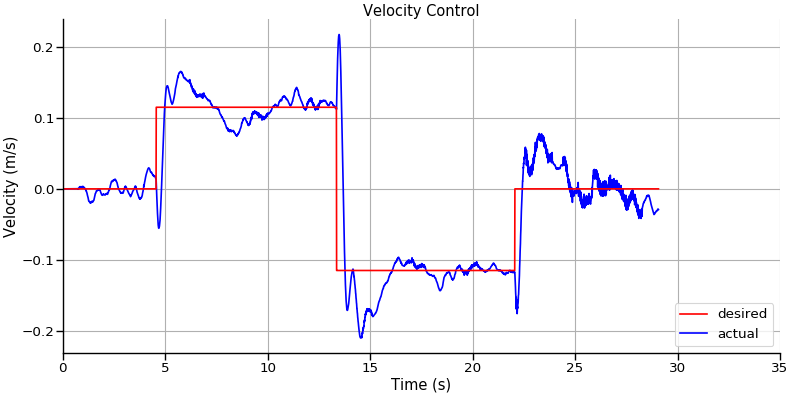

In [42]:
%matplotlib inline
cfg = pc['velocity_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'VelocityControl', plot_func=desired_vs_actual_for_runs)

In order to drive forward and backward, Bobble-Bot's velocity controller commands a 
positive and then negative tilt to the tilt controller. The effort sent to each motor 
in order to track this tilt command causes the robot to drive forward and then backward. 
We can confirm this behavior by analyzing the tilt controller performance.

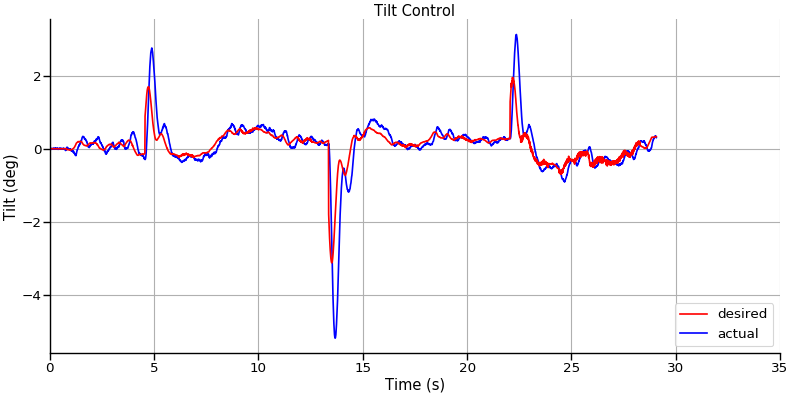

In [43]:
%matplotlib inline
cfg = pc['tilt_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'TiltControl', plot_func=desired_vs_actual_for_runs)

The plots above confirm the velocity and tilt control performance during the balance test.
Let's now look at the turning commands that were sent during the test.

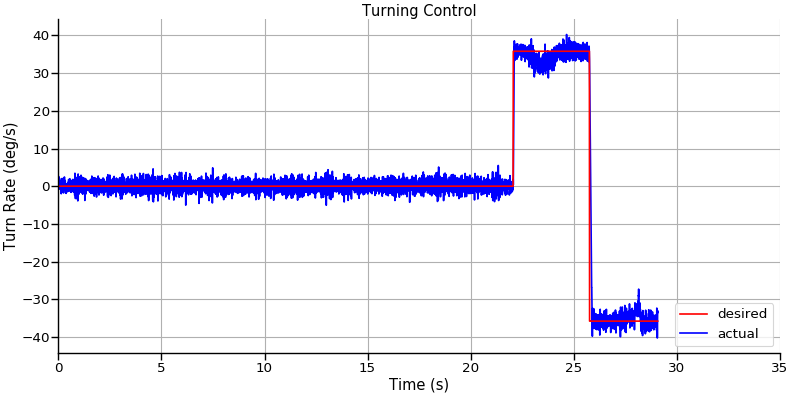

In [44]:
%matplotlib inline
cfg = pc['turning_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'TurningControl', plot_func=desired_vs_actual_for_runs)

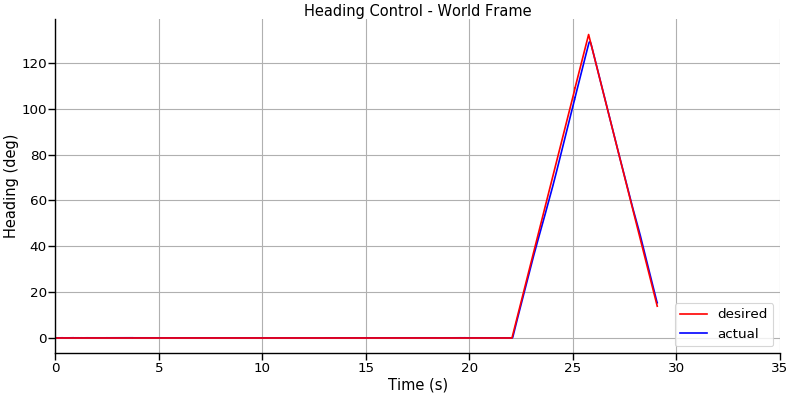

In [45]:
%matplotlib inline
cfg = pc['heading_control'].copy()
cfg['runs'] = ['balance']
cfg['xlim'] = [0, 35]
make_static_plot(df, cfg, 'HeadingControl', plot_func=desired_vs_actual_for_runs)

This concludes our analysis of the balance test. The last test to look at is the drive square test. 
This is done in the next section.

## Analyzing the Drive Square Test
Last on our list of tests is the drive square test. This test is performed by issuing a canned 
set of joystick commands to drive Bobble-Bot in a square. These commands were generated by 
manually driving the robot during a simulation run and logging the joystick command data 
using [rosbag record](http://wiki.ros.org/rosbag/Tutorials/Recording%20and%20playing%20back%20data).
The previous sections have served to validate the velocity, tilt, and turning controller. This 
final plot will show all of these controllers working together to track a commanded trajectory. 
The plot below shows the commanded position in X,Y world coordinates versus the actual X,Y 
position.

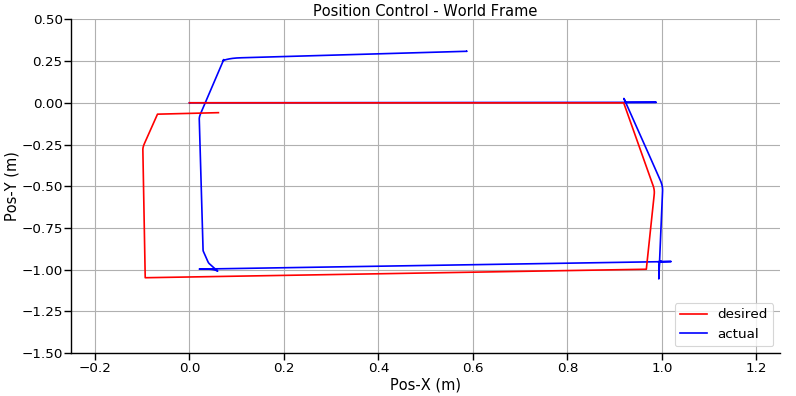

In [46]:
%matplotlib inline
cfg = pc['position_control'].copy()
cfg['runs'] = ['drive_square_js_response']
cfg['xlim'] = [-0.25, 1.25]
cfg['ylim'] = [-1.5, 0.5]
make_static_plot(df, cfg, 'PositionControl', plot_func=desired_vs_actual_for_runs)

# Conclusion
Automated integration tests are a great way to ensure that the Bobble-Bot balance control code always 
remains in working order. This is a useful capability for open-source code as it gives developers 
a set of automated tests to evaluate the feasability of their proposed changes to the code base. 
It is a relatively short report that should be reviewed prior to accepting any merge request to 
the balance controller code base. ROS test, GitLab CI, ROS bag, Pandas, and Jupyter are all working 
together to produce this automated summary report for every change to the Bobble-Bot balance controller. 
Special thanks to the developers of those tools for making something like this possible.

### Contact
Mike Moore

mike.moore@so.engineering
